In [1]:
import os
import shutil
import time
import json

In [2]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, Sequential
from keras.src.applications.convnext import ConvNeXtXLarge
from keras.src.applications.efficientnet_v2 import EfficientNetV2L
from keras.src.applications.inception_resnet_v2 import InceptionResNetV2
from keras.src.applications.resnet_v2 import ResNet50V2
from keras.src.applications.vgg16 import VGG16
from keras.src.applications.xception import Xception
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.utils import image_dataset_from_directory
from pandas import DataFrame
from plot_keras_history import show_history

2024-09-17 21:26:04.643253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 21:26:04.694263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 21:26:04.711838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 21:26:04.804174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 21:26:05.832795: W tensorflow/compiler/tf2

In [3]:
CROPPED_IMAGES_PATH = "resources/Cropped_Images"
MODELS_PATH = "models/transfer_learning"

In [4]:
def remove_last_generated_models():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)

In [5]:
def get_dataset(path, image_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [6]:
def create_model(image_size, base_model):
    for layer in base_model.layers:
        layer.trainable = False
        
    data_augmentation_layers = Sequential([
        layers.RandomFlip("horizontal", input_shape=image_size + (3,)),
        layers.RandomRotation(0.1)
    ])
    
    model = Sequential([
        # Data preparation
        data_augmentation_layers,
        layers.Rescaling(1. / 127.5, offset=-1),

        # Pre-trained model without the top
        base_model,

        # Convert the feature map from the encoder part of the model (without the top) to a vector
        layers.GlobalAveragePooling2D(),

        # Fully connected layers (all neurons are linked to the others).
        layers.Dense(256, activation='relu'),

        # Dropout layer to prevent overfitting. Randomly stops some neurons for each image so that the other neurons have to adapt to that, to reduce overfitting.
        # Not the latest method to do this, batch normalization for example is better. Check more online.
        layers.Dropout(0.5),

        # Output layer with the same layer as your labels. Softmax to allow the model to predict the probability of each class.
        layers.Dense(120, activation='softmax')
    ])

    # Crossentropy as we're getting closer to a correct prediction of the labels.
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # print(model.summary())
    return model

In [7]:
def get_base_model(base_model, image_size):
    input_shape = image_size + (3,)
    preprocessing_input = keras.layers.Input([224, 224, 3])
    
    match base_model:
        case "VGG16":
            return (VGG16(include_top=False, weights="imagenet", input_shape=input_shape,
                          input_tensor=keras.applications.vgg16.preprocess_input(preprocessing_input)))
        case "Xception":
            return (Xception(include_top=False, weights="imagenet", input_shape=input_shape,
                             input_tensor=keras.applications.xception.preprocess_input(preprocessing_input)))
        case "ResNet50V2":
            return (ResNet50V2(include_top=False, weights="imagenet", input_shape=input_shape,
                               input_tensor=keras.applications.resnet_v2.preprocess_input(preprocessing_input)))
        case "InceptionResNetV2":
            return (InceptionResNetV2(include_top=False, weights="imagenet", input_shape=input_shape,
                                      input_tensor=keras.applications.inception_resnet_v2.preprocess_input(
                                          preprocessing_input)))
        case "EfficientNetV2L":
            # The preprocessing logic has been included in the EfficientNetV2 model implementation.
            return EfficientNetV2L(include_top=False, weights="imagenet", input_shape=input_shape)
        case "ConvNeXtXLarge":
            # The preprocessing logic has been included in the convnext model implementation.
            return ConvNeXtXLarge(include_top=False, weights="imagenet", input_shape=input_shape)
        case _:
            return None

In [8]:
def display_results_plots(results):
    display_results_plot(results, ["fitting_time"], "fitting_time")
    display_results_plot(results, ["test_accuracy", "val_accuracy"], "accuracies", ascending=False)
    display_results_plot(results, ["test_loss", "val_loss"], "losses")

In [9]:
def display_results_plot(results, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)

    performance_plot = (results[metrics + ["model_name"]]
                        .plot(kind="line", x="model_name", figsize=(15, 8), rot=0,
                              title=f"Models Sorted by {metrics_name}"))
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    performance_plot.set(xlabel=None)

    plt.show()
    plt.close()

Starting transfer learning script.

Found 20580 files belonging to 120 classes.
Using 15435 files for training.


I0000 00:00:1726583168.256542    7119 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726583168.393835    7119 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726583168.397205    7119 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726583168.401131    7119 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 20580 files belonging to 120 classes.
Using 5145 files for validation.
Found 20580 files belonging to 120 classes.
Training model VGG16.

Epoch 1/100


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-09-17 21:26:12.645810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726583172.775645    7316 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583172.795833    7316 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583172.799113    7316 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583172.802832    7316 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583172.806023    7316 gpu_timer.cc:114] Skippi

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0098 - loss: 4.9573

W0000 00:00:1726583224.837201    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.838218    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.839202    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.840272    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.841277    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.842502    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.843714    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.845312    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583224.847240    7315 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0098 - loss: 4.9570

W0000 00:00:1726583226.417417    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.420841    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.424325    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.427961    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.431190    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.434440    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.438058    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.441235    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583226.444773    7315 gp


Epoch 1: val_loss improved from inf to 4.76511, saving model to models/transfer_learning/VGG16_best_weights.keras


W0000 00:00:1726583246.039761    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583246.043203    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583246.048036    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726583246.055178    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


483/483 ━━━━━━━━━━━━━━━━━━━━ 75s 142ms/step - accuracy: 0.0098 - loss: 4.9568 - val_accuracy: 0.0138 - val_loss: 4.7651
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0115 - loss: 4.7662
Epoch 2: val_loss improved from 4.76511 to 4.73778, saving model to models/transfer_learning/VGG16_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - accuracy: 0.0115 - loss: 4.7661 - val_accuracy: 0.0155 - val_loss: 4.7378
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0145 - loss: 4.7409
Epoch 3: val_loss improved from 4.73778 to 4.72114, saving model to models/transfer_learning/VGG16_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 64s 132ms/step - accuracy: 0.0145 - loss: 4.7409 - val_accuracy: 0.0142 - val_loss: 4.7211
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0183 - loss: 4.7315
Epoch 4: val_loss improved from 4.72114 to 4.71121, saving model to models/transfer_learning/VGG16_best_weights.keras
483/483 ━━━━━━━━━━━━

W0000 00:00:1726584861.973221    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.974012    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.974764    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.975566    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.976354    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.977192    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.978023    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.979013    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584861.980190    7317 gp


Test Accuracy:0.02954324521124363.



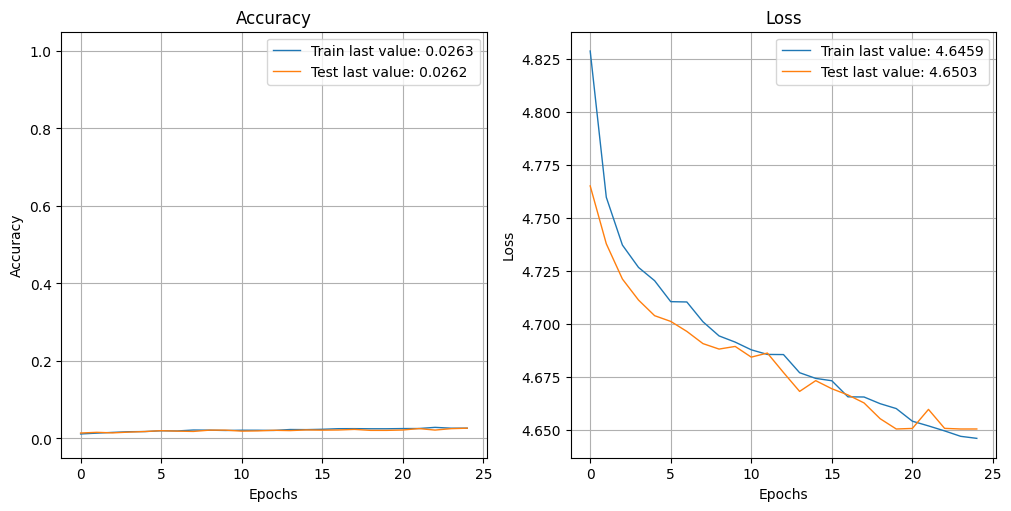

Training model Xception.

Epoch 1/100


W0000 00:00:1726584866.741396    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.742254    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.743072    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.743927    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.744809    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.745671    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.746549    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.747704    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584866.748855    7313 gp

  3/483 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.0191 - loss: 4.8105

W0000 00:00:1726584867.161789    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.162721    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.163643    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.164634    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.165572    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.166526    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.167510    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.168470    7313 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584867.169423    7313 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0117 - loss: 4.7859

W0000 00:00:1726584901.111637    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.112326    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.112992    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.113654    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.114303    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.114946    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.115611    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.116327    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.117043    7314 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0117 - loss: 4.7858

W0000 00:00:1726584901.313724    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.314441    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.315170    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.315883    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.316593    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.317318    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.318049    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.318788    7314 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584901.319519    7314 gp


Epoch 1: val_loss improved from inf to 4.72151, saving model to models/transfer_learning/Xception_best_weights.keras


W0000 00:00:1726584913.148644    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.149908    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.151179    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.152463    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.153741    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.155018    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.156321    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.157614    7318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726584913.159087    7318 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - accuracy: 0.0117 - loss: 4.7858 - val_accuracy: 0.0161 - val_loss: 4.7215
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0197 - loss: 4.7102
Epoch 2: val_loss improved from 4.72151 to 4.66688, saving model to models/transfer_learning/Xception_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 94ms/step - accuracy: 0.0197 - loss: 4.7102 - val_accuracy: 0.0173 - val_loss: 4.6669
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0228 - loss: 4.6731
Epoch 3: val_loss improved from 4.66688 to 4.63356, saving model to models/transfer_learning/Xception_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 94ms/step - accuracy: 0.0228 - loss: 4.6730 - val_accuracy: 0.0206 - val_loss: 4.6336
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0251 - loss: 4.6444
Epoch 4: val_loss improved from 4.63356 to 4.61162, saving model to models/transfer_learning/Xception_best_weights.keras
483/483 ━━━━━━━━

W0000 00:00:1726588571.470661    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.471305    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.471919    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.472554    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.473191    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.473823    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.474454    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.475095    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588571.475738    7312 gp


Test Accuracy:0.10626821964979172.



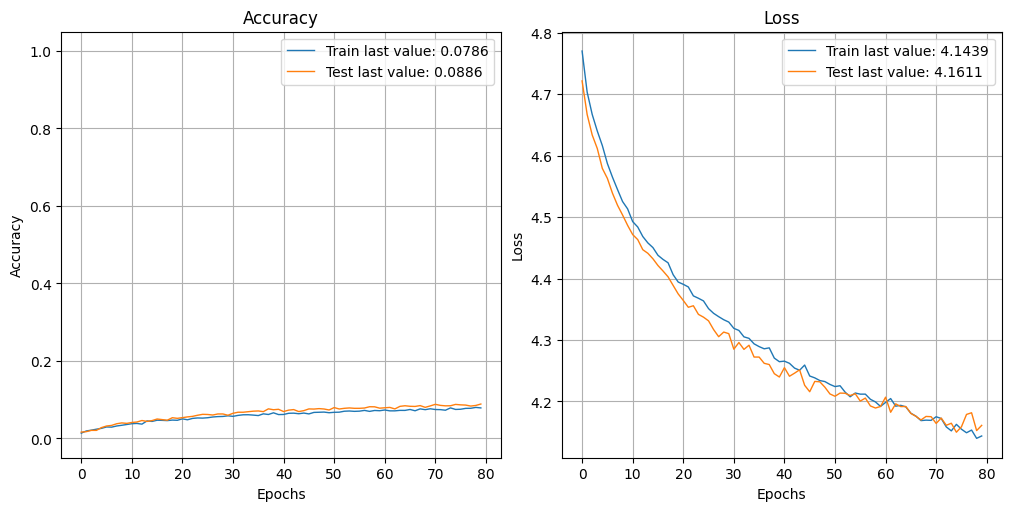

Training model ResNet50V2.

Epoch 1/100


W0000 00:00:1726588576.398222    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.399753    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.401260    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.402908    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.404765    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.406859    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.408993    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.412632    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.415348    7315 gp

  3/483 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.0191 - loss: 5.1521

W0000 00:00:1726588576.799970    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.800819    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.801597    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.802379    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.803181    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.803969    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.804754    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.805561    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588576.806320    7315 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0176 - loss: 4.7715

W0000 00:00:1726588603.491936    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.492858    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.493749    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.494689    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.495693    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.496990    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.498052    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.499312    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.500382    7315 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0176 - loss: 4.7714

W0000 00:00:1726588603.692844    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.693600    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.703981    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.704767    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.705519    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.706281    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.707011    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.707756    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588603.708503    7315 gp


Epoch 1: val_loss improved from inf to 4.54029, saving model to models/transfer_learning/ResNet50V2_best_weights.keras


W0000 00:00:1726588613.597006    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.597930    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.599138    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.600187    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.601184    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.602440    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.603687    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.605204    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726588613.606515    7317 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.0176 - loss: 4.7713 - val_accuracy: 0.0377 - val_loss: 4.5403
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0329 - loss: 4.5536
Epoch 2: val_loss improved from 4.54029 to 4.42375, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.0329 - loss: 4.5535 - val_accuracy: 0.0472 - val_loss: 4.4238
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0450 - loss: 4.4519
Epoch 3: val_loss improved from 4.42375 to 4.35246, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.0450 - loss: 4.4518 - val_accuracy: 0.0536 - val_loss: 4.3525
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0542 - loss: 4.3863
Epoch 4: val_loss improved from 4.35246 to 4.26855, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
483/483 ━━

W0000 00:00:1726590370.526444    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.527188    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.527892    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.528624    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.529365    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.530215    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.530966    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.531808    7311 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590370.532567    7311 gp


Test Accuracy:0.15262390673160553.



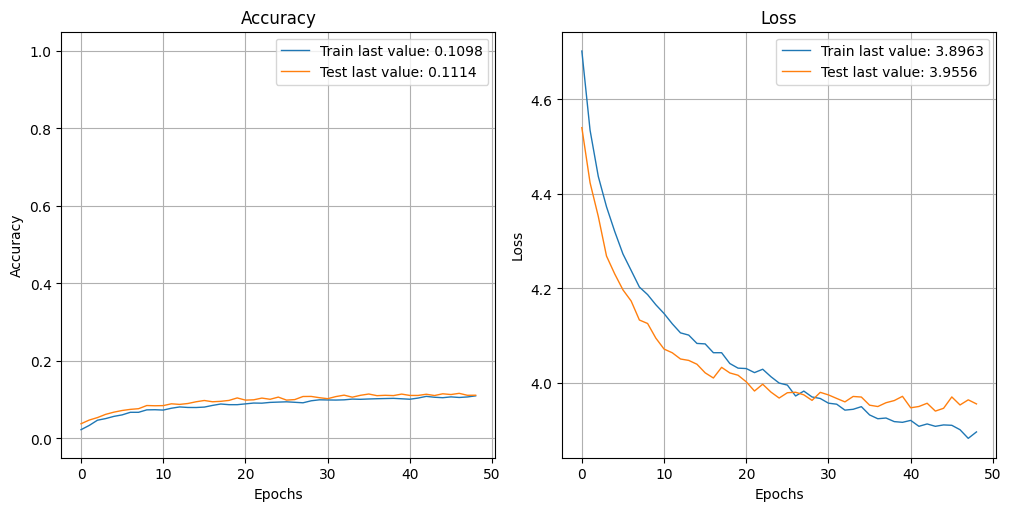

Training model InceptionResNetV2.

Epoch 1/100


W0000 00:00:1726590383.883039    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.884516    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.885979    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.887929    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.889323    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.891307    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.893372    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.894926    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590383.896973    7315 gp

  2/483 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.0000e+00 - loss: 4.8655   

W0000 00:00:1726590385.384530    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.385102    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.385695    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.386284    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.386878    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.387475    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.388049    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.388647    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590385.389245    7315 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0114 - loss: 4.7921

W0000 00:00:1726590428.221264    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.222141    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.222997    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.224021    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.224867    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.225878    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.226907    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.227778    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590428.228810    7315 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.0114 - loss: 4.7920

W0000 00:00:1726590445.795734    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.796949    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.798135    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.799668    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.800805    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.802342    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.803950    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.805197    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590445.806813    7317 gp


Epoch 1: val_loss improved from inf to 4.71674, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras


W0000 00:00:1726590446.958732    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.959853    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.960758    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.961822    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.962907    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.963965    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.965038    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.965948    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726590446.966940    7317 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 75s 132ms/step - accuracy: 0.0114 - loss: 4.7920 - val_accuracy: 0.0163 - val_loss: 4.7167
Epoch 2/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0226 - loss: 4.7116
Epoch 2: val_loss improved from 4.71674 to 4.66319, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 58s 121ms/step - accuracy: 0.0226 - loss: 4.7115 - val_accuracy: 0.0200 - val_loss: 4.6632
Epoch 3/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0215 - loss: 4.6718
Epoch 3: val_loss improved from 4.66319 to 4.64139, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 58s 121ms/step - accuracy: 0.0215 - loss: 4.6718 - val_accuracy: 0.0220 - val_loss: 4.6414
Epoch 4/100
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0248 - loss: 4.6555
Epoch 4: val_loss improved from 4.64139 to 4.60538, saving model to models/transfer_learning/InceptionResNetV2_best_

W0000 00:00:1726592453.669112    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.669872    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.670603    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.671376    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.672080    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.672840    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.673593    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.674287    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592453.675054    7315 gp


Test Accuracy:0.05422740429639816.



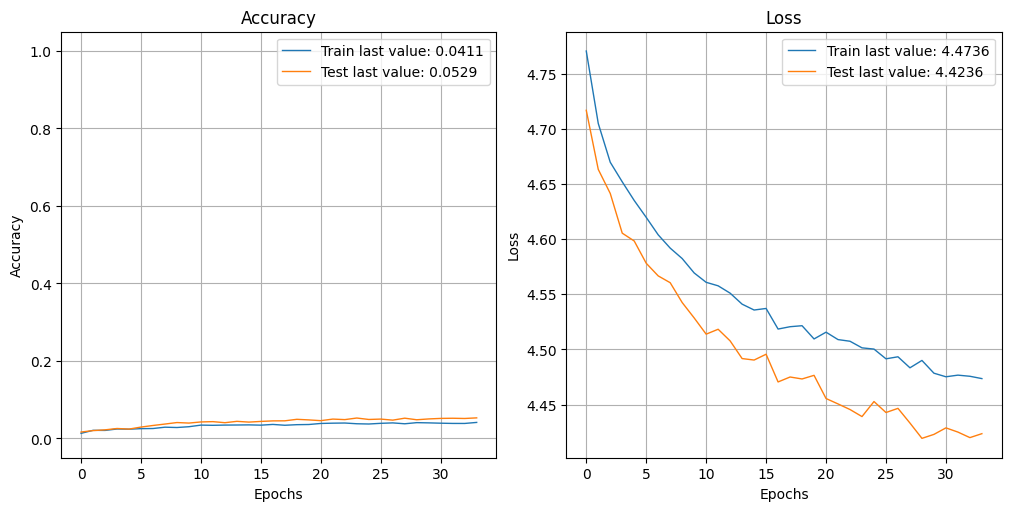

Training model EfficientNetV2L.

Epoch 1/100


W0000 00:00:1726592483.333388    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.334239    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.335098    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.335956    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.336814    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.337685    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.338550    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.339708    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592483.340876    7315 gp

  1/483 ━━━━━━━━━━━━━━━━━━━━ 3:27:49 26s/step - accuracy: 0.0312 - loss: 4.7969

W0000 00:00:1726592484.234907    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.236692    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.238490    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.240862    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.243028    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.245554    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.247545    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.249660    7315 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592484.251770    7315 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.0095 - loss: 4.7956

W0000 00:00:1726592592.214518    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.215206    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.215879    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.216560    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.217211    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.217858    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.218579    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.219222    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.219941    7317 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.0095 - loss: 4.7956

W0000 00:00:1726592592.415680    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.417463    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.420176    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.422433    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.435866    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.438748    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.439555    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.440361    7317 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726592592.441176    7317 gp


Epoch 1: val_loss improved from inf to 4.77055, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 177s 313ms/step - accuracy: 0.0095 - loss: 4.7956 - val_accuracy: 0.0239 - val_loss: 4.7706
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.0146 - loss: 4.7712
Epoch 2: val_loss improved from 4.77055 to 4.72653, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 146s 302ms/step - accuracy: 0.0146 - loss: 4.7712 - val_accuracy: 0.0200 - val_loss: 4.7265
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.0180 - loss: 4.7457
Epoch 3: val_loss improved from 4.72653 to 4.69111, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 146s 302ms/step - accuracy: 0.0180 - loss: 4.7457 - val_accuracy: 0.0262 - val_loss: 4.6911
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.0180 - lo

W0000 00:00:1726601022.778726    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.779382    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.779999    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.780838    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.781512    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.782180    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.782872    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.783491    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601022.784116    7305 gp


Test Accuracy:0.0980563685297966.



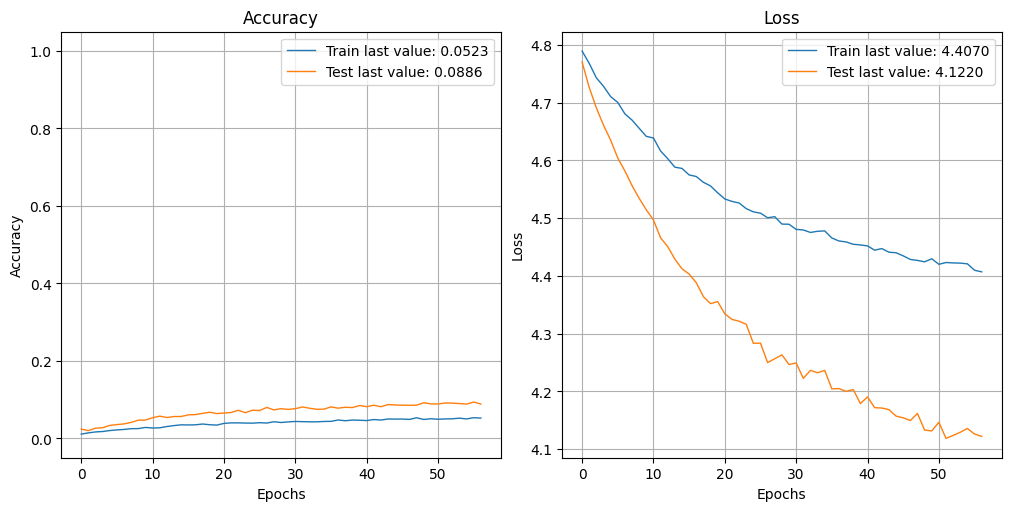

Training model ConvNeXtXLarge.

Epoch 1/100


W0000 00:00:1726601036.379230    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.380350    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.381437    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.382497    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.383747    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.384994    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.386208    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.387440    7305 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601036.388675    7305 gp

482/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.5403 - loss: 2.1450

W0000 00:00:1726601993.830732    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.831633    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.832489    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.833370    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.834300    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.835241    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.836194    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.837387    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726601993.838515    7304 gp

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5406 - loss: 2.1433

W0000 00:00:1726602314.454503    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.455627    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.456760    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.457836    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.459075    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.460401    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.461686    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.462942    7304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726602314.464085    7304 gp


Epoch 1: val_loss improved from inf to 0.57461, saving model to models/transfer_learning/ConvNeXtXLarge_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 1293s 3s/step - accuracy: 0.5409 - loss: 2.1417 - val_accuracy: 0.8270 - val_loss: 0.5746
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7808 - loss: 0.8169
Epoch 2: val_loss improved from 0.57461 to 0.52878, saving model to models/transfer_learning/ConvNeXtXLarge_best_weights.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 1282s 3s/step - accuracy: 0.7808 - loss: 0.8169 - val_accuracy: 0.8431 - val_loss: 0.5288
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7895 - loss: 0.7505
Epoch 3: val_loss did not improve from 0.52878
483/483 ━━━━━━━━━━━━━━━━━━━━ 1278s 3s/step - accuracy: 0.7895 - loss: 0.7505 - val_accuracy: 0.8383 - val_loss: 0.5445
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7958 - loss: 0.7265
Epoch 4: val_loss did not improve from 0.52878
483/483 ━━━━━━━━━━━━━━━━━━━━ 1278s 3s/st

W0000 00:00:1726611695.998289    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611695.999095    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611695.999855    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611696.000637    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611696.001389    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611696.002111    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611696.002842    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611696.003649    7312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726611696.004433    7312 gp


Test Accuracy:0.8637998104095459.



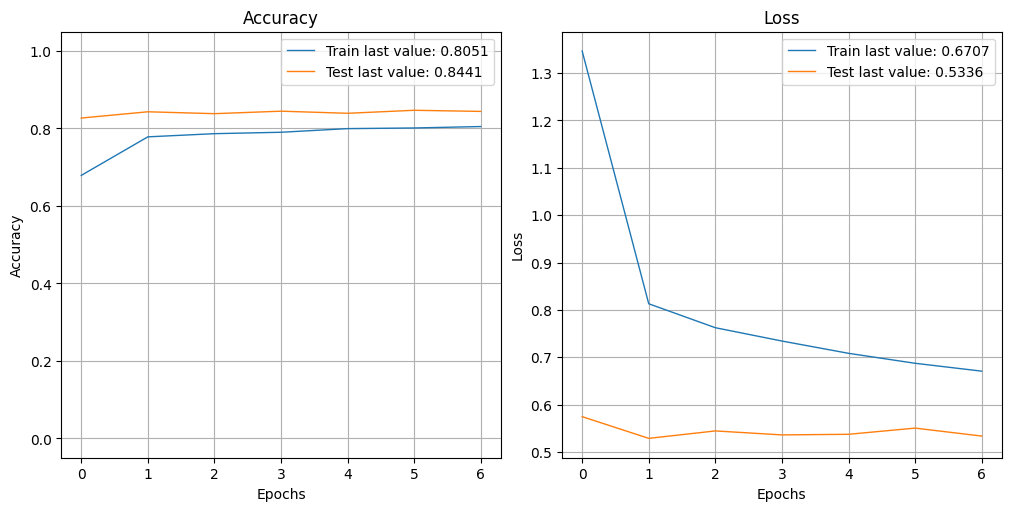

Displaying all results.



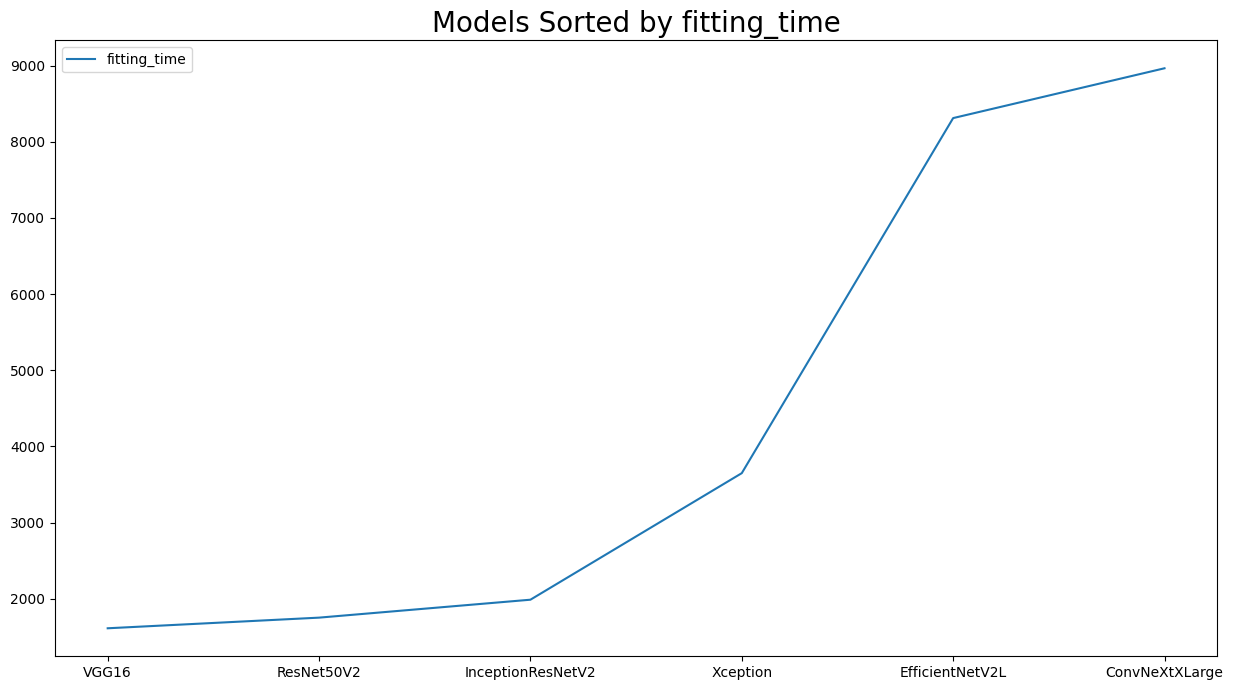

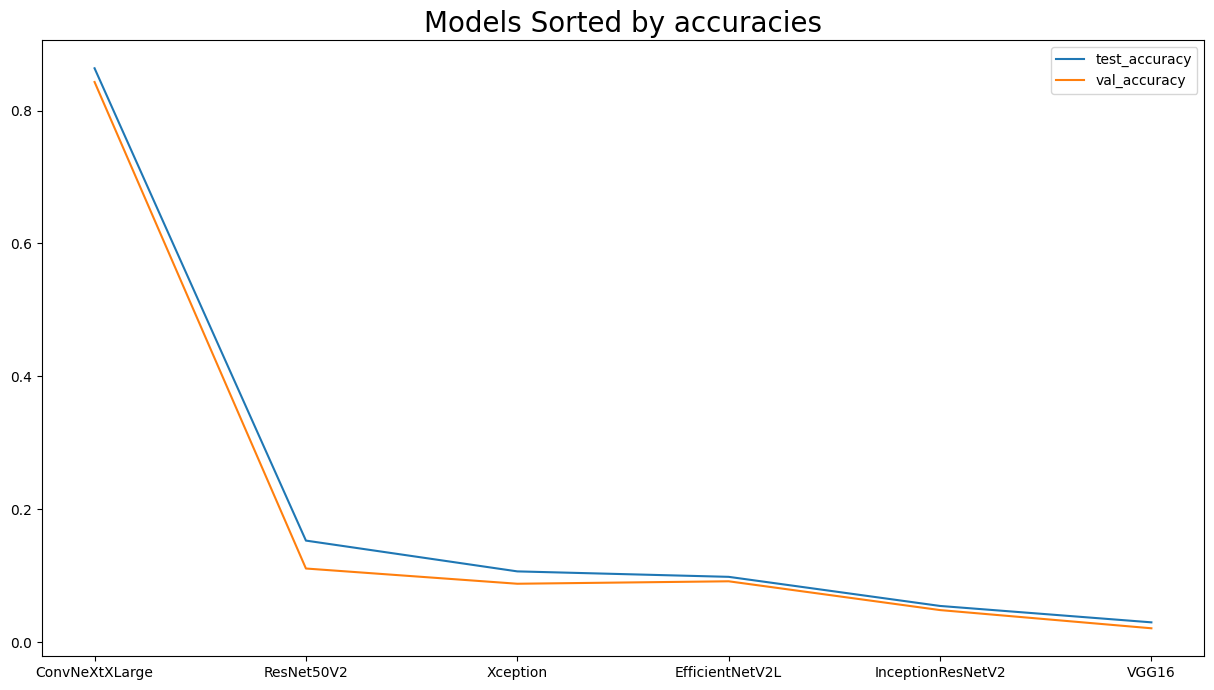

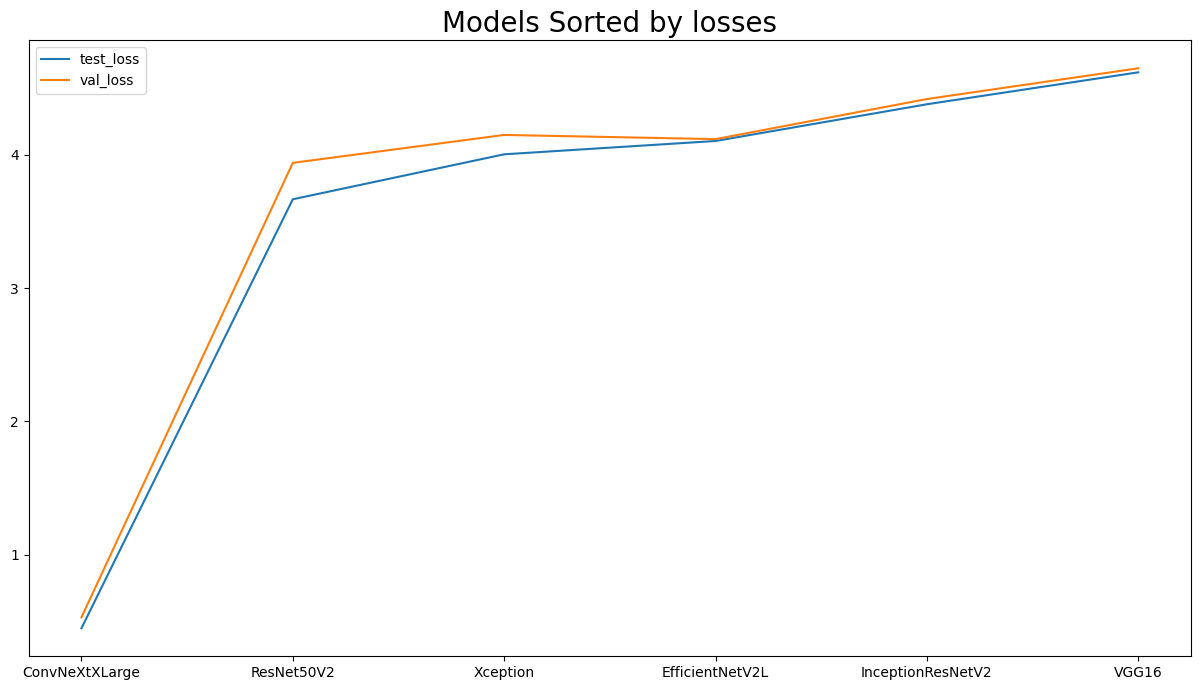

The transfer learning script is now finished.



In [10]:
print("Starting transfer learning script.\n")
remove_last_generated_models()

image_size = (224, 224)
batch_size = 32

dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, validation_split=0.25, data_type='training')
dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, validation_split=0.25, data_type='validation')
dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, data_type=None)

with tf.device('/gpu:0'):
    histories = []
    results = []
    
    for model_name in [
        "VGG16",
        "Xception",
        "ResNet50V2",
        "InceptionResNetV2",
        "EfficientNetV2L",
        "ConvNeXtXLarge"
    ]:
        print(f"Training model {model_name}.\n")

        base_model = get_base_model(model_name, image_size)

        model = create_model(image_size, base_model)
        model_save_path = f"{MODELS_PATH}/{model_name}_best_weights.keras"

        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                                     mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        callbacks_list = [checkpoint, es]

        fitting_start_time = time.time()
        history = model.fit(dataset_train,
                            validation_data=dataset_val,
                            batch_size=batch_size,
                            # epochs=2,  # Test value
                            epochs=100,  # We want early stopping to stop the training itself
                            callbacks=callbacks_list,
                            verbose=1)
        fitting_time = time.time() - fitting_start_time

        histories.append(history)
        print("The model has been fitted, checking their loss and accuracy.\n")

        # Getting optimal epoch weights
        model.load_weights(model_save_path)

        val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
        print(f"\nValidation Accuracy:{val_accuracy}.\n")

        test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
        print(f"\nTest Accuracy:{test_accuracy}.\n")

        results.append({
            "model_name": model_name,
            "fitting_time": fitting_time,
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss
        })

        show_history(history)
        plt.close()
    
    print("Displaying all results.\n")
    display_results_plots(DataFrame(results))

print("The transfer learning script is now finished.\n")